In [62]:
%matplotlib inline
import matplotlib.pyplot as plt
import scipy.stats as stats
from matplotlib_venn import venn2
from collections import OrderedDict, defaultdict
import seaborn as sns
import pandas as pd
import numpy as np
import os
import glob
import gffutils
import statsmodels.api as sm 
from scipy.stats import ranksums
from scipy.stats import mannwhitneyu

pd.set_option("display.max_rows", 500)

### EPKM Data

In [63]:
input_dir = '/home/rmarina/projects/apobec/revision_riboseq_comparison/first_torin_experiment/output/'
output_dir = '/home/rmarina/projects/apobec/revision_riboseq_comparison/outputs/epkm_reconstruct/epkm_all_samples/cds_plus_3utr/figures/'

In [64]:
RPS2_control_1 = os.path.join(input_dir, 'RPS2-T_1_conf0_epkm_table_cds_3utr.txt')
RPS2_control_2 = os.path.join(input_dir, 'RPS2-T_2_conf0_epkm_table_cds_3utr.txt')
RPS2_torin_1 = os.path.join(input_dir, 'RPS2_plusT_1_conf0_epkm_table_cds_3utr.txt')
RPS2_torin_2 = os.path.join(input_dir, 'RPS2_plusT_2_conf0_epkm_table_cds_3utr.txt')


APO_control_1 = os.path.join(input_dir, 'Apobec-T_1_conf0_epkm_table_cds_3utr.txt')
APO_control_2 = os.path.join(input_dir, 'Apobec-T_2_conf0_epkm_table_cds_3utr.txt')
APO_torin_1 = os.path.join(input_dir, 'Apobec_plusT_1_conf0_epkm_table_cds_3utr.txt')
APO_torin_2 = os.path.join(input_dir, 'Apobec_plusT_2_conf0_epkm_table_cds_3utr.txt')

#### Expression Data
- Goal is try and remove non-protein coding genes AND any histone genes deteced in the respective samples
- use gffutils methods that Brain wrote
- NEED to determine protein coding 

In [65]:
histone = '/home/rmarina/projects/apobec/ref_files/HIST_genes.csv'
histone_genes = pd.read_csv(histone, index_col=0)
histone_genes = histone_genes[['Genename']]
histone_genes.to_csv('/home/rmarina/projects/apobec/ref_files/hg19_histone_genes.txt', sep='\t')
histone_genes.head()

,Genename
Geneid,
ENSG00000168298.4,HIST1H1E
ENSG00000187837.2,HIST1H1C
ENSG00000197061.3,HIST1H4C
ENSG00000198518.5,HIST1H4E
ENSG00000124693.2,HIST1H3B


In [66]:
# The counts file itself is completely arbitrary sicne we're just trying to extract protein coding information and will be later fitted to CDS+3UTR counts detection later
expression_dir = '/home/rmarina/projects/apobec/revision_riboseq_comparison/first_torin_experiment/input/'
all_gene_counts = pd.read_csv(os.path.join(expression_dir, 'counts.txt'), sep='\t', comment='#').drop(['Chr', 'Start', 'End', 'Strand'],axis=1)

In [67]:
all_gene_counts.head()

,Geneid,Length,../results/Apobec_plusT_1_S30_L003_R1_001.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted.bam,../results/Apobec_plusT_2_S31_L003_R1_001.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted.bam,../results/Apobec-T_1_S28_L003_R1_001.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted.bam,../results/Apobec-T_2_S29_L003_R1_001.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted.bam,../results/RBFOX2_plusT_1_S34_L003_R1_001.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted.bam,../results/RBFOX2_plusT_2_S35_L003_R1_001.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted.bam,../results/RBFOX2-T_1_S32_L003_R1_001.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted.bam,../results/RBFOX2-T_2_S33_L003_R1_001.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted.bam,../results/RPS2_plusT_1_S38_L003_R1_001.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted.bam,../results/RPS2_plusT_2_S39_L003_R1_001.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted.bam,../results/RPS2-T_1_S36_L003_R1_001.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted.bam,../results/RPS2-T_2_S37_L003_R1_001.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted.bam,../results/Tia1_0ng_1_S40_L003_R1_001.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted.bam,../results/Tia1_0ng_2_S41_L003_R1_001.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted.bam,../results/Tia1_1000ng_1_S14_L001_R1_001.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted.bam,../results/Tia1_1000ng_2_S27_L002_R1_001.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted.bam,../results/Tia1_50ng_1_S42_L003_R1_001.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted.bam,../results/Tia1_50ng_2_S13_L001_R1_001.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted.bam
0,ENSG00000223972.4,1756,0,2,0,0,2,2,0,1,1,0,1,0,0,0,0,0,0,0
1,ENSG00000227232.4,2073,22,37,0,10,43,40,0,21,80,59,55,82,3,4,24,29,8,38
2,ENSG00000243485.2,1021,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,ENSG00000237613.2,1219,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,ENSG00000268020.2,947,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [68]:
rename_dict = {}

for x in all_gene_counts.columns[1:]:
    rename_dict[x] = os.path.basename(x).split('_S')[0]

    
all_gene_counts = all_gene_counts.rename(columns=rename_dict)
all_gene_counts_sub = all_gene_counts[['Geneid', 'Length']]

#### Helper functions for protein coding determination 

In [69]:
def gene_id_to_protein_coding(db):
    """
    returns whether or not a gene is protein coding or not.
    """
    genes = db.features_of_type('gene')
    gene_name_dict = {}
    for gene in genes:
        gene_id = gene.attributes['gene_id'][0] if type(gene.attributes['gene_id']) == list else gene.attributes['gene_id']
        try:
            gene_name_dict[gene_id] = gene.attributes['gene_type'][0]
        except KeyError:
            print(gene.attributes.keys())
            print("Warning. Key not found for {}".format(gene))
            return 1
    return gene_name_dict

def gene_id_to_name(db):
    """
    Returns a dictionary containing a gene_id:name translation
    NOTE: This assumes ENSEMBL-STYLE notations, which is different from the above function.
    """
    genes = db.features_of_type('gene')
    gene_name_dict = {}
    for gene in genes:
        gene_id = gene.attributes['gene_id'][0] if type(gene.attributes['gene_id']) == list else gene.attributes['gene_id']
        try:
            gene_name_dict[gene_id.split('.')[0]] = gene.attributes['gene_name'][0]  # this is for ENSEMBL-style IDs! 
        except KeyError:
            print(gene.attributes.keys())
            print("Warning. Key not found for {}".format(gene))
            return 1
    return gene_name_dict

db_file = '/projects/ps-yeolab4/genomes/hg19/gencode_v19/gencode.v19.annotation.gtf.db'
DATABASE = gffutils.FeatureDB(db_file)
gene_id_to_pc = gene_id_to_protein_coding(DATABASE)
gene_id_to_name = gene_id_to_name(DATABASE)

/projects/ps-yeolab4/software/yeolabconda3/envs/python3essential-0.0.1/lib/python3.6/site-packages/gffutils/interface.py:161: UserWarning: It appears that this database has not had the ANALYZE sqlite3 command run on it. Doing so can dramatically speed up queries, and is done by default for databases created with gffutils >0.8.7.1 (this database was created with version 0.8.1) Consider calling the analyze() method of this object.
  "method of this object." % self.version)


In [70]:
def get_gene_is_pc(row, d=gene_id_to_pc):
    """
    Helper function that uses the gene_id_to_pc dictionary to assign whether or not
    a gene is protein coding. Returns 'unannotated' in case the geneid doesn't exist
    in the dictionary.
    """
    try:
        return d[row['Geneid']]
    except KeyError:
        return 'unannotated'

In [71]:
all_gene_counts_sub['gene_type'] = all_gene_counts_sub.apply(get_gene_is_pc, axis=1)
# might as well save since I think this will be pretty useful
# all_gene_counts_sub[['Geneid','gene_type']].to_csv('/home/rmarina/projects/apobec/ref_files/hg19_v19_geneid_type.txt', index=False, sep='\t') 
all_gene_counts_pc = all_gene_counts_sub[all_gene_counts_sub['gene_type'] == 'protein_coding']
all_gene_counts_pc.set_index('Geneid', inplace=True, drop=True)

/projects/ps-yeolab4/software/yeolabconda3/envs/python3essential-0.0.1/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [72]:
# removing histone protein coding genes now and leaving everything else behind 
all_gene_counts_pc = all_gene_counts_pc[~all_gene_counts_pc.index.isin(histone_genes.index)]

In [73]:
# Last thing is to change the geneids back to the abbreviated form
all_gene_counts_pc_geneid = all_gene_counts_pc.reset_index()
all_gene_counts_pc_geneid['Geneid'] = all_gene_counts_pc_geneid['Geneid'].apply(lambda x: x.split('.')[0])
all_gene_counts_pc_geneid.set_index('Geneid', drop=True, inplace=True)

In [74]:
all_gene_counts_pc_geneid.head()

,Length,gene_type
Geneid,,
ENSG00000186092,918,protein_coding
ENSG00000237683,2661,protein_coding
ENSG00000235249,995,protein_coding
ENSG00000185097,995,protein_coding
ENSG00000269831,129,protein_coding


### NEW layer-- want to add RPKM expression data to analyses for quartile plotting

In [75]:
counts_file = '/home/rmarina/projects/apobec/revision_riboseq_comparison/first_torin_experiment/input/cds_3utr_counts.txt'

cds_utr_counts = pd.read_csv(counts_file, sep='\t', index_col=0, comment='#').drop(['Chr', 'Start', 'End', 'Strand'], axis=1)

In [76]:
rename_dict = defaultdict()

for c in cds_utr_counts.columns[1:]:
    rename_dict[c] = os.path.basename(c).split('_S')[0]

cds_utr_counts = cds_utr_counts.rename(columns=rename_dict)

In [77]:
def counts_to_rpkm(counts_df):
    counts = counts_df[counts_df.columns[1:]]
    rpm = counts.div(counts.sum() / 10**6, axis=1)
    length = counts_df['Length'] / 1000
    rpkm = rpm.div(length, axis=0)
    return rpkm

In [78]:
stamp_rpkm = counts_to_rpkm(cds_utr_counts)

### Combining all data into concatenated dataframes

In [79]:
# Taking RPKM from each dataset and concatenating into one sample identified table 

# RPS2 samples
control_1 = pd.read_csv(RPS2_control_1, sep='\t', index_col=0)
control_2 = pd.read_csv(RPS2_control_2, sep='\t', index_col=0)
torin_1 = pd.read_csv(RPS2_torin_1, sep='\t', index_col=0)
torin_2 = pd.read_csv(RPS2_torin_2, sep='\t', index_col=0)


# APO samples
apo_control_1 = pd.read_csv(APO_control_1, sep='\t', index_col=0)
apo_control_2 = pd.read_csv(APO_control_2, sep='\t', index_col=0)
apo_torin_1 = pd.read_csv(APO_torin_1, sep='\t', index_col=0)
apo_torin_2 = pd.read_csv(APO_torin_2, sep='\t', index_col=0)

apo_torin_1['sample'] = 'APO+Torin1-R1'
apo_torin_2['sample'] = 'APO+Torin1-R2'


print(len(apo_control_1))
print(len(apo_control_2))
print(len(apo_torin_1))
print(len(apo_torin_2))

print(len(control_1))
print(len(control_2))
print(len(torin_1))
print(len(torin_2))

14328
15389
15126
15306
15403
15457
15579
15445


#### Newly added--RPKM data

In [80]:
# Adding RPKM
control_1_rpkm = pd.merge(control_1, stamp_rpkm['RPS2-T_1'], how='left', left_index=True, right_index=True)
control_1_rpkm.rename(columns={'RPS2-T_1':'STAMP_RPKM'}, inplace=True)

control_2_rpkm = pd.merge(control_2, stamp_rpkm['RPS2-T_2'], how='left', left_index=True, right_index=True)
control_2_rpkm.rename(columns={'RPS2-T_2':'STAMP_RPKM'}, inplace=True)

torin_1_rpkm = pd.merge(torin_1, stamp_rpkm['RPS2_plusT_1'], how='left', left_index=True, right_index=True)
torin_1_rpkm.rename(columns={'RPS2_plusT_1':'STAMP_RPKM'}, inplace=True)

torin_2_rpkm = pd.merge(torin_2, stamp_rpkm['RPS2_plusT_2'], how='left', left_index=True, right_index=True)
torin_2_rpkm.rename(columns={'RPS2_plusT_2':'STAMP_RPKM'}, inplace=True)


apo_control_1_rpkm = pd.merge(apo_control_1, stamp_rpkm['Apobec-T_1'], how='left', left_index=True, right_index=True)
apo_control_1_rpkm.rename(columns={'Apobec-T_1':'STAMP_RPKM'}, inplace=True)

apo_control_2_rpkm = pd.merge(apo_control_2, stamp_rpkm['Apobec-T_2'], how='left', left_index=True, right_index=True)
apo_control_2_rpkm.rename(columns={'Apobec-T_2':'STAMP_RPKM'}, inplace=True)

apo_torin_1_rpkm = pd.merge(apo_torin_1, stamp_rpkm['Apobec_plusT_1'], how='left', left_index=True, right_index=True)
apo_torin_1_rpkm.rename(columns={'Apobec_plusT_1':'STAMP_RPKM'}, inplace=True)

apo_torin_2_rpkm = pd.merge(apo_torin_2, stamp_rpkm['Apobec_plusT_2'], how='left', left_index=True, right_index=True)
apo_torin_2_rpkm.rename(columns={'Apobec_plusT_2':'STAMP_RPKM'}, inplace=True)

In [81]:
def combine_and_average_reps(EPKM_df1, EPKM_df2):
    combined = pd.merge(EPKM_df1[['EPKM', 'STAMP_RPKM']], EPKM_df2[['EPKM', 'STAMP_RPKM']], how='inner', left_index=True, right_index=True)
    combined['mean_EPKM'] = (combined['EPKM_x'] + combined['EPKM_y']) / 2
    combined['mean_RPKM'] = (combined['STAMP_RPKM_x'] + combined['STAMP_RPKM_y']) / 2
    return combined

In [82]:
# Averaging reps for RPS2
control_combined = combine_and_average_reps(control_1_rpkm, control_2_rpkm)
control_combined['sample'] = 'RPS2-Torin1'
control_combined = control_combined[['mean_EPKM', 'mean_RPKM', 'sample']]

torin_combined = combine_and_average_reps(torin_1_rpkm, torin_2_rpkm)
torin_combined['sample'] = 'RPS2+Torin1'
torin_combined = torin_combined[['mean_EPKM', 'mean_RPKM', 'sample']]


# And APO
apo_control_combined = combine_and_average_reps(apo_control_1_rpkm, apo_control_2_rpkm)
apo_control_combined['sample'] = 'APO-Torin1'
apo_control_combined = apo_control_combined[['mean_EPKM', 'mean_RPKM', 'sample']]

apo_torin_combined = combine_and_average_reps(apo_torin_1_rpkm, apo_torin_2_rpkm)
apo_torin_combined['sample'] = 'APO+Torin1'
apo_torin_combined = apo_torin_combined[['mean_EPKM', 'mean_RPKM', 'sample']]

In [83]:
# RPS2 samples

cont_genes = set(control_combined.index)
torin_genes = set(torin_combined.index)


common_genes = list(cont_genes.intersection(torin_genes))


rps_epkm_combined = pd.concat([control_combined, torin_combined], join='inner', axis=0)[['mean_EPKM', 'mean_RPKM', 'sample']].sort_index()
rps_epkm_combined = rps_epkm_combined.loc[common_genes]

In [84]:
# APO control samples

apo_cont_genes = set(apo_control_combined.index)
apo_torin_genes = set(apo_torin_combined.index)


apo_common_genes = list(apo_cont_genes.intersection(apo_torin_genes))


apo_epkm_combined = pd.concat([apo_control_combined, apo_torin_combined], join='inner', axis=0)[['mean_EPKM', 'mean_RPKM', 'sample']].sort_index()
apo_epkm_combined = apo_epkm_combined.loc[apo_common_genes]

In [85]:
# lastly, only keep those which are protein_coding and lacking histone annotation
rps_epkm_combined = rps_epkm_combined.loc[rps_epkm_combined.index.isin(all_gene_counts_pc_geneid.index)]
apo_epkm_combined = apo_epkm_combined.loc[apo_epkm_combined.index.isin(all_gene_counts_pc_geneid.index)]

In [86]:
print(len(rps_epkm_combined)) # Still fewer genes in the APO control set if that matters
print(len(apo_epkm_combined))

28780
27348


### Polysome data from Fred
- Reading in RPKM information, ranking into percentiles and determining occupancy quartiles

In [87]:
polysome = '/home/rmarina/projects/apobec/revision_riboseq_comparison/ribosome_files/fred_x3_polysome_RPKM.txt'

polysome_rpkm = pd.read_csv(polysome, sep='\t',index_col=0)
polysome_rpkm.head()

,x3_input,x3_polysome,poly/input
Geneid,,,
ENSG00000262227,1.386483,0.000000,0.000000
ENSG00000273243,1.615120,0.000000,0.000000
ENSG00000254207,1.450542,0.215213,0.148368
ENSG00000230359,1.473046,0.542613,0.368361
ENSG00000105880,1.390836,0.430654,0.309637


### Combinding polysome data with EPKM values
- only accounting for genes that are reported in both datasets

In [88]:
epkm_ribo_combined = pd.merge(polysome_rpkm['poly/input'], rps_epkm_combined, how='right', left_index=True, right_index=True).fillna(0) # only keeping those from our editing datasets
apo_epkm_ribo_combined = pd.merge(polysome_rpkm['poly/input'], apo_epkm_combined, how='right', left_index=True, right_index=True).fillna(0)


epkm_ribo_combined.head(12)

,poly/input,mean_EPKM,mean_RPKM,sample
ENSG00000000003,2.834096,0.601243,57.380318,RPS2-Torin1
ENSG00000000003,2.834096,0.471155,74.920631,RPS2+Torin1
ENSG00000000005,0.000000,0.000000,0.127349,RPS2-Torin1
ENSG00000000005,0.000000,0.000000,0.053267,RPS2+Torin1
ENSG00000000419,3.468370,0.234409,53.752803,RPS2-Torin1
ENSG00000000419,3.468370,0.000000,38.813449,RPS2+Torin1
ENSG00000000457,1.363360,0.009449,4.103479,RPS2+Torin1
ENSG00000000457,1.363360,0.000000,3.285469,RPS2-Torin1
ENSG00000000460,1.998907,0.083621,11.431872,RPS2-Torin1
ENSG00000000460,1.998907,0.028296,13.719903,RPS2+Torin1


#### Assigning quartiles based upon normalized polysome values

In [89]:
def get_quartile2(row):
    """
    Simpler function than the one above. Basically just look at row['pct']
    which should come from Pandas.rank() function. Quartiles are assigned 
    based on... quartiles.
    """
    if row['pct'] > 0.75 and row['pct'] <= 1:
        return 1
    if row['pct'] > 0.5 and row['pct'] <= 0.75:
        return 2
    if row['pct'] > 0.25 and row['pct'] <= 0.5:
        return 3
    return 4

In [90]:
epkm_ribo_combined['pct'] = epkm_ribo_combined['poly/input'].rank(pct=True)
epkm_ribo_combined['Occupancy Quartile'] = epkm_ribo_combined.apply(get_quartile2, axis=1)

apo_epkm_ribo_combined['pct'] = apo_epkm_ribo_combined['poly/input'].rank(pct=True)
apo_epkm_ribo_combined['Occupancy Quartile'] = apo_epkm_ribo_combined.apply(get_quartile2, axis=1)

epkm_ribo_combined.head(12)

,poly/input,mean_EPKM,mean_RPKM,sample,pct,Occupancy Quartile
ENSG00000000003,2.834096,0.601243,57.380318,RPS2-Torin1,0.962804,1
ENSG00000000003,2.834096,0.471155,74.920631,RPS2+Torin1,0.962804,1
ENSG00000000005,0.000000,0.000000,0.127349,RPS2-Torin1,0.142373,4
ENSG00000000005,0.000000,0.000000,0.053267,RPS2+Torin1,0.142373,4
ENSG00000000419,3.468370,0.234409,53.752803,RPS2-Torin1,0.983026,1
ENSG00000000419,3.468370,0.000000,38.813449,RPS2+Torin1,0.983026,1
ENSG00000000457,1.363360,0.009449,4.103479,RPS2+Torin1,0.839385,1
ENSG00000000457,1.363360,0.000000,3.285469,RPS2-Torin1,0.839385,1
ENSG00000000460,1.998907,0.083621,11.431872,RPS2-Torin1,0.914646,1
ENSG00000000460,1.998907,0.028296,13.719903,RPS2+Torin1,0.914646,1


In [91]:
rps2_genes_no = int(len(epkm_ribo_combined) / 2)
apo_genes_no = int(len(apo_epkm_ribo_combined) / 2)

In [92]:
# Log transforming EPKM values 
epkm_ribo_combined['log2(EPKM+1)'] = np.log2(epkm_ribo_combined['mean_EPKM']+1)
epkm_ribo_combined['log2(STAMP RPKM+1)'] = np.log2(epkm_ribo_combined['mean_RPKM']+1)
apo_epkm_ribo_combined['log2(EPKM+1)'] = np.log2(apo_epkm_ribo_combined['mean_EPKM']+1)
apo_epkm_ribo_combined['log2(STAMP RPKM+1)'] = np.log2(apo_epkm_ribo_combined['mean_RPKM']+1)

In [93]:
# Calculating P-values using Mann-Whitney test as Brian had done before

pvalues = defaultdict()

for quartile in [1, 2, 3, 4]:
    arr1 = epkm_ribo_combined[(epkm_ribo_combined['sample']=='RPS2-Torin1') & (epkm_ribo_combined['Occupancy Quartile']==quartile)]['log2(EPKM+1)']
    arr2 = epkm_ribo_combined[(epkm_ribo_combined['sample']=='RPS2+Torin1') & (epkm_ribo_combined['Occupancy Quartile']==quartile)]['log2(EPKM+1)']
    stat, pvalue = ranksums(x=arr1, y=arr2)  # Wilcoxon rank-sum
    mwu_stat, mwu_pvalue = mannwhitneyu(x=arr1, y=arr2, alternative='greater')  # Mann Whitney U test
    pvalues[quartile] = mwu_pvalue

In [94]:
pvalues

defaultdict(None,
            {1: 7.700615764151639e-108,
             2: 3.47491318025118e-56,
             3: 5.999836721585709e-19,
             4: 1.0594347274226562e-14})

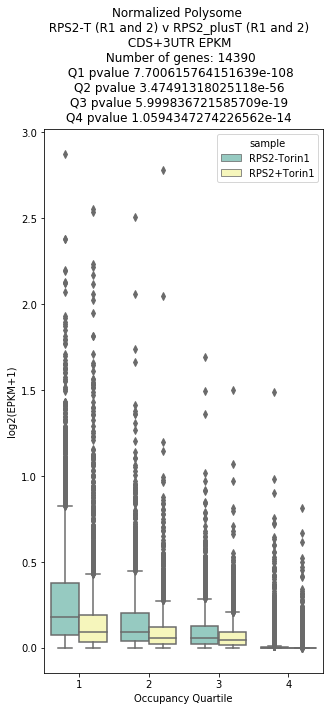

In [95]:
# Plotting quartile values 

fig, ax = plt.subplots(figsize=(5, 10))

sns.boxplot(x="Occupancy Quartile", 
            y='log2(EPKM+1)', 
            hue="sample",
            data=epkm_ribo_combined, 
            hue_order=['RPS2-Torin1','RPS2+Torin1'],
            ax=ax, palette="Set3", showfliers=True, 
        )



fig.suptitle('Normalized Polysome \n RPS2-T (R1 and 2) v RPS2_plusT (R1 and 2) \n CDS+3UTR EPKM \n Number of genes: {}\n Q1 pvalue {}\nQ2 pvalue {}\nQ3 pvalue {}\nQ4 pvalue {}'.format(
    rps2_genes_no,pvalues[1], pvalues[2], pvalues[3], pvalues[4]), y=1.05)


fig.savefig(output_dir+'RPS2-T_reps_combined_vs_RPS2_plusT_reps_combined_EPKM_boxplot_polysome.svg', dpi=300)

### Look at RPKM compared to polysome-seq

In [96]:
pvalues = defaultdict()

for quartile in [1, 2, 3, 4]:
    arr1 = epkm_ribo_combined[(epkm_ribo_combined['sample']=='RPS2-Torin1') & (epkm_ribo_combined['Occupancy Quartile']==quartile)]['log2(STAMP RPKM+1)']
    arr2 = epkm_ribo_combined[(epkm_ribo_combined['sample']=='RPS2+Torin1') & (epkm_ribo_combined['Occupancy Quartile']==quartile)]['log2(STAMP RPKM+1)']
    stat, pvalue = ranksums(x=arr1, y=arr2)  # Wilcoxon rank-sum
    mwu_stat, mwu_pvalue = mannwhitneyu(x=arr1, y=arr2, alternative='greater')  # Mann Whitney U test
    pvalues[quartile] = mwu_pvalue

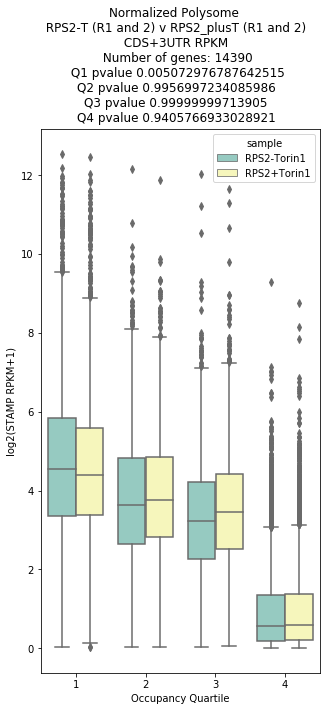

In [97]:
fig, ax = plt.subplots(figsize=(5, 10))

sns.boxplot(x="Occupancy Quartile", 
            y='log2(STAMP RPKM+1)', 
            hue="sample",
            data=epkm_ribo_combined, 
            hue_order=['RPS2-Torin1','RPS2+Torin1'],
            ax=ax, palette="Set3", showfliers=True, 
        )



fig.suptitle('Normalized Polysome \n RPS2-T (R1 and 2) v RPS2_plusT (R1 and 2) \n CDS+3UTR RPKM \n Number of genes: {}\n Q1 pvalue {}\nQ2 pvalue {}\nQ3 pvalue {}\nQ4 pvalue {}'.format(
    rps2_genes_no,pvalues[1], pvalues[2], pvalues[3], pvalues[4]), y=1.05)


fig.savefig(output_dir+'RPS2-T_reps_combined_vs_RPS2_plusT_reps_combined_RPKM_boxplot_polysome.svg', dpi=300)

### APO

In [98]:
apo_epkm_ribo_combined.head()

,poly/input,mean_EPKM,mean_RPKM,sample,pct,Occupancy Quartile,log2(EPKM+1),log2(STAMP RPKM+1)
ENSG00000000003,2.834096,0.046811,115.133344,APO-Torin1,0.960856,1,0.066001,6.859638
ENSG00000000003,2.834096,0.033186,97.132852,APO+Torin1,0.960856,1,0.047100,6.616664
ENSG00000000419,3.468370,0.000000,91.971304,APO-Torin1,0.982138,1,0.000000,6.538714
ENSG00000000419,3.468370,0.000000,52.204820,APO+Torin1,0.982138,1,0.000000,5.733485
ENSG00000000457,1.363360,0.008845,5.169145,APO-Torin1,0.831121,1,0.012704,2.625070


In [99]:
pvalues = defaultdict()

for quartile in [1, 2, 3, 4]:
    arr1 = apo_epkm_ribo_combined[(apo_epkm_ribo_combined['sample']=='APO-Torin1') & (apo_epkm_ribo_combined['Occupancy Quartile']==quartile)]['log2(EPKM+1)']
    arr2 = apo_epkm_ribo_combined[(apo_epkm_ribo_combined['sample']=='APO+Torin1') & (apo_epkm_ribo_combined['Occupancy Quartile']==quartile)]['log2(EPKM+1)']
    stat, pvalue = ranksums(x=arr1, y=arr2)  # Wilcoxon rank-sum
    mwu_stat, mwu_pvalue = mannwhitneyu(x=arr1, y=arr2, alternative='greater')  # Mann Whitney U test
    pvalues[quartile] = mwu_pvalue

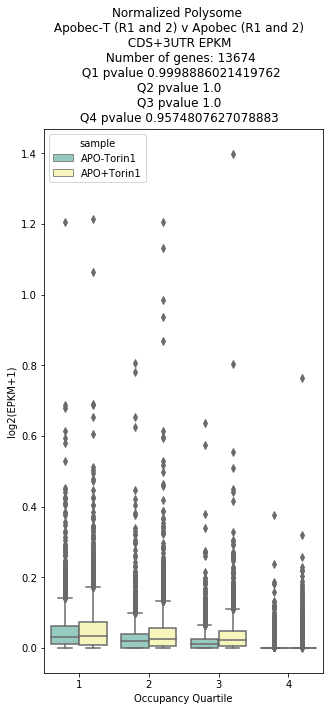

In [100]:
# Plotting quartile values 

fig, ax = plt.subplots(figsize=(5, 10))

sns.boxplot(x="Occupancy Quartile", 
            y='log2(EPKM+1)', 
            hue="sample",
            data=apo_epkm_ribo_combined, 
            hue_order=['APO-Torin1','APO+Torin1'],
            ax=ax, palette="Set3", showfliers=True, 
        )



fig.suptitle('Normalized Polysome \n Apobec-T (R1 and 2) v Apobec (R1 and 2) \n CDS+3UTR EPKM \n Number of genes: {}\n Q1 pvalue {}\nQ2 pvalue {}\nQ3 pvalue {}\nQ4 pvalue {}'.format(
    apo_genes_no,pvalues[1], pvalues[2], pvalues[3], pvalues[4]), y=1.05)

fig.savefig(output_dir+'Apobec-T_reps_combined_vs_Apobec_plusT_reps_combined_EPKM_boxplot_polysome.svg', dpi=300)

In [101]:
#pval for apo RPKM
apo_pvalues = defaultdict()

for quartile in [1, 2, 3, 4]:
    arr1 = apo_epkm_ribo_combined[(apo_epkm_ribo_combined['sample']=='APO-Torin1') & (apo_epkm_ribo_combined['Occupancy Quartile']==quartile)]['log2(STAMP RPKM+1)']
    arr2 = apo_epkm_ribo_combined[(apo_epkm_ribo_combined['sample']=='APO+Torin1') & (apo_epkm_ribo_combined['Occupancy Quartile']==quartile)]['log2(STAMP RPKM+1)']
    stat, pvalue = ranksums(x=arr1, y=arr2)  # Wilcoxon rank-sum
    mwu_stat, mwu_pvalue = mannwhitneyu(x=arr1, y=arr2, alternative='greater')  # Mann Whitney U test
    apo_pvalues[quartile] = mwu_pvalue

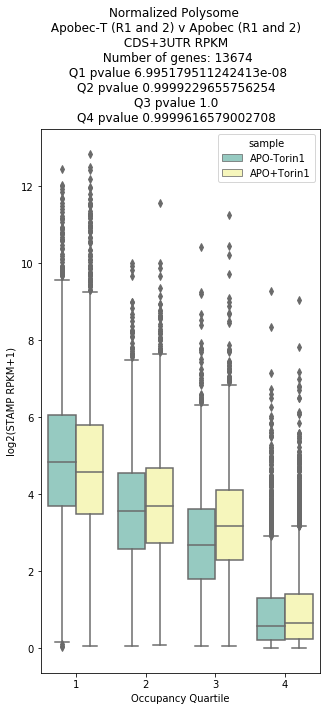

In [102]:
fig, ax = plt.subplots(figsize=(5, 10))

sns.boxplot(x="Occupancy Quartile", 
            y='log2(STAMP RPKM+1)', 
            hue="sample",
            data=apo_epkm_ribo_combined, 
            hue_order=['APO-Torin1','APO+Torin1'],
            ax=ax, palette="Set3", showfliers=True, 
        )



fig.suptitle('Normalized Polysome \n Apobec-T (R1 and 2) v Apobec (R1 and 2) \n CDS+3UTR RPKM \n Number of genes: {}\n Q1 pvalue {}\nQ2 pvalue {}\nQ3 pvalue {}\nQ4 pvalue {}'.format(
    apo_genes_no,apo_pvalues[1], apo_pvalues[2], apo_pvalues[3], apo_pvalues[4]), y=1.05)

fig.savefig(output_dir+'Apobec-T_reps_combined_vs_Apobec_plusT_reps_combined_RPKM_boxplot_polysome.svg', dpi=300)

### Comparing Q1 genes to actual values found in datasets 
* Trying to see how expression compares with edit counts

In [103]:
q1_genes = epkm_ribo_combined.loc[epkm_ribo_combined['Occupancy Quartile'] == 1]
q1_genes_torin = q1_genes.loc[q1_genes['sample'] == 'RPS2+Torin1']
q1_genes_dmso = q1_genes.loc[q1_genes['sample'] == 'RPS2-Torin1']

# for comparison, do the same for Q4
q4_genes = epkm_ribo_combined.loc[epkm_ribo_combined['Occupancy Quartile'] == 4]
q4_genes_torin = q4_genes.loc[q4_genes['sample'] == 'RPS2+Torin1']
q4_genes_dmso = q4_genes.loc[q4_genes['sample'] == 'RPS2-Torin1']

In [104]:
q1_genes_torin['log2(poly/input)'] = np.log2(q1_genes_torin['poly/input']+1)
q1_genes_dmso['log2(poly/input)'] = np.log2(q1_genes_dmso['poly/input']+1)

q4_genes_torin['log2(poly/input)'] = np.log2(q4_genes_torin['poly/input']+1)
q4_genes_dmso['log2(poly/input)'] = np.log2(q4_genes_dmso['poly/input']+1)

/projects/ps-yeolab4/software/yeolabconda3/envs/python3essential-0.0.1/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/projects/ps-yeolab4/software/yeolabconda3/envs/python3essential-0.0.1/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/projects/ps-yeolab4/software/yeolabconda3/envs/python3essential-0.0.1/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value 

In [105]:
from scipy.stats import pearsonr

In [106]:
def r2pearson(x,y):
    return pearsonr(x,y)[0] ** 2

/projects/ps-yeolab4/software/yeolabconda3/envs/python3essential-0.0.1/lib/python3.6/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


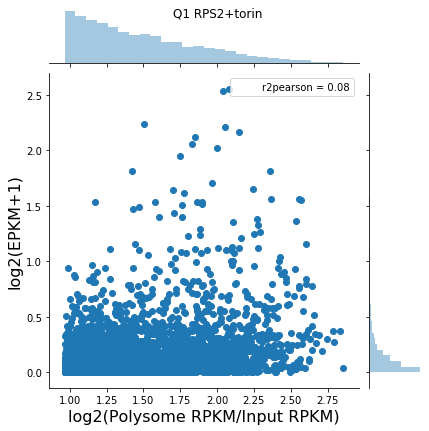

In [107]:
# Q1 for RPS2+torin versus polysome ratio
g = sns.jointplot(data=q1_genes_torin, x='log2(poly/input)', y='log2(EPKM+1)', stat_func=r2pearson)
g.fig.suptitle("Q1 RPS2+torin")
g.set_axis_labels('log2(Polysome RPKM/Input RPKM)', 'log2(EPKM+1)', fontsize=16)
g.savefig(output_dir+'Q1_EPKM_scatter_RPS2_Torin1_CDS_3UTR_vs_polysome.pdf', bbox_inches='tight', dpi=300)

/projects/ps-yeolab4/software/yeolabconda3/envs/python3essential-0.0.1/lib/python3.6/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


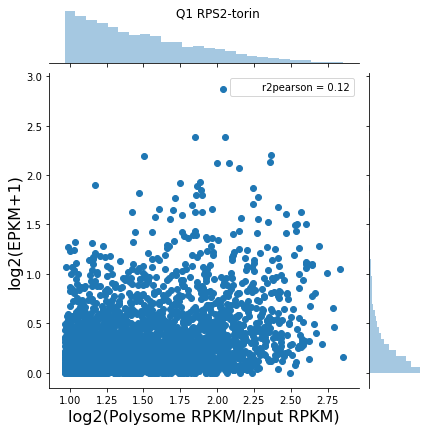

In [108]:
# Q1 for RPS2-torin versus polysome ratio
g = sns.jointplot(data=q1_genes_dmso, x='log2(poly/input)', y='log2(EPKM+1)', stat_func=r2pearson)
g.fig.suptitle("Q1 RPS2-torin")
g.set_axis_labels('log2(Polysome RPKM/Input RPKM)', 'log2(EPKM+1)', fontsize=16)
g.savefig(output_dir+'Q1_EPKM_scatter_RPS2_vehicle_CDS_3UTR_vs_polysome.pdf', bbox_inches='tight', dpi=300)

/projects/ps-yeolab4/software/yeolabconda3/envs/python3essential-0.0.1/lib/python3.6/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))
/projects/ps-yeolab4/software/yeolabconda3/envs/python3essential-0.0.1/lib/python3.6/site-packages/scipy/stats/stats.py:3038: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


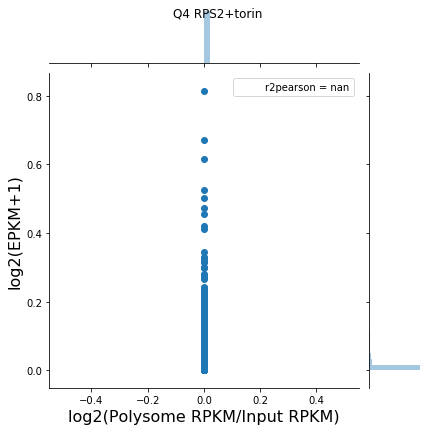

In [109]:
# Q4 for RPS2+torin versus ribo-seq RPKM
g = sns.jointplot(data=q4_genes_torin, x='log2(poly/input)', y='log2(EPKM+1)', stat_func=r2pearson)
g.fig.suptitle("Q4 RPS2+torin")
g.set_axis_labels('log2(Polysome RPKM/Input RPKM)', 'log2(EPKM+1)', fontsize=16)
g.savefig(output_dir+'Q4_EPKM_scatter_RPS2_Torin1_CDS_3UTR_vs_polysome.pdf', bbox_inches='tight', dpi=300)

/projects/ps-yeolab4/software/yeolabconda3/envs/python3essential-0.0.1/lib/python3.6/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))
/projects/ps-yeolab4/software/yeolabconda3/envs/python3essential-0.0.1/lib/python3.6/site-packages/scipy/stats/stats.py:3038: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


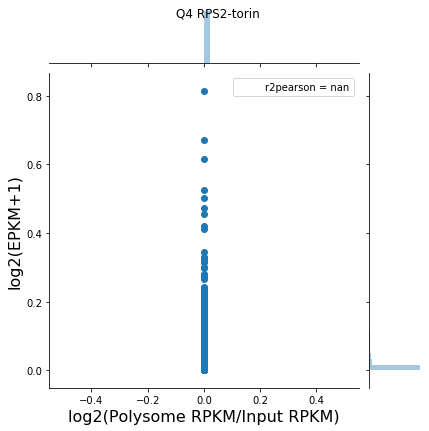

In [110]:
# Q4 for RPS2-torin versus ribo-seq RPKM
g = sns.jointplot(data=q4_genes_torin, x='log2(poly/input)', y='log2(EPKM+1)', stat_func=r2pearson)
g.fig.suptitle("Q4 RPS2-torin")
g.set_axis_labels('log2(Polysome RPKM/Input RPKM)', 'log2(EPKM+1)', fontsize=16)
g.savefig(output_dir+'Q4_EPKM_scatter_RPS2_vehicle_CDS_3UTR_vs_polysome.pdf', bbox_inches='tight', dpi=300)